<a href="https://colab.research.google.com/github/marciamart/Classificacao-Ecommerce/blob/main/classifica%C3%A7%C3%A3o_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####intalações e importações

In [ ]:
!pip install opendatasets
!apt install libimage-exiftool-perl
!pip install colorgram.py
!pip install imagehash
!pip install opencv-python
!pip install tensorflow

In [ ]:
import opendatasets as od
import os
from PIL import Image
import subprocess
import imghdr
from collections import Counter
import colorgram
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imagehash
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.decomposition import PCA
import shutil

In [ ]:
od.download("https://www.kaggle.com/datasets/fatihkgg/ecommerce-product-images-18k")

#USAR API TOKEN DO KAGGLE

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mrciamartins
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fatihkgg/ecommerce-product-images-18k


100%|██████████| 142M/142M [00:01<00:00, 84.2MB/s]


Dataset em  /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES

In [ ]:
data_dir = '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES'
train_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train"
val_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val"
test_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check"

# Parte 1 - Análise do DataSet

## Objetivo e informações esperadas

Objetivo:
* Apresentar informações do dataset.

Informações esperadas:
* Integridade dos Arquivos
  1. Verifique se todas as imagens listadas no arquivo de informações
realmente existem no diretório de imagens e vice-versa.
  2. Verifique se todas as imagens estão no mesmo formato, ex: JPEG,
PNG, etc.
* Consistência dos Metadados
  1. Verifique se há valores ausentes nos metadados e como esses casos
são tratados.
  2. Verifique valores inconsistentes, por exemplo: dimensões de imagens
fora do esperado.
* Qualidade das Imagens
  1. Identifique imagens corrompidas que não podem ser abertas ou
processadas.
* Distribuição das Classes
  1. Verifique a distribuição das classes para identificar possíveis
desequilíbrios que possam afetar a modelagem
* Duplicatas
  1. Identifique imagens duplicadas que possam enviesar os resultados.
  2. Verifique duplicatas no arquivo de informações.

Informações complementares:
* Elaborar uma apresentação para mostrar os resultados.
* Apresentar o dataset de forma detalhada.
* Verifique quais itens em Informações esperadas podem ser aplicados no
dataset.

## **Integridade dos Arquivos**
A função a seguir verifica se todas as imagens no diretório estão no mesmo formato (JPEG, JPG, PNG). Ela retorna um dicionário com os formatos das imagens como chaves e suas respectivas quantidades como valores.

Saída esperada: {'JPEG': 18175}

In [ ]:
def verificar_formato_imagem(data):
    formatos = {}
    for raiz, dirs, arquivos in os.walk(data):
        print(raiz)
        for arquivo in arquivos:
            if arquivo.endswith(('jpeg', 'jpg', 'png')):
                caminho_arquivo = os.path.join(raiz, arquivo)
                with Image.open(caminho_arquivo) as img:
                    formato = img.format
                    if formato not in formatos:
                        formatos[formato] = 0
                    formatos[formato] += 1
            else:
                formatos['Desconhecido'] = formatos.get('Desconhecido', 0) + 1

    return formatos

formatos_imagens = verificar_formato_imagem(data)
print(formatos_imagens)

/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/BEAUTY_HEALTH
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/CLOTHING_ACCESSORIES_JEWELLERY
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/GROCERY
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/SPORTS_OUTDOOR
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/ELECTRONICS
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/HOME_KITCHEN_TOOLS
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/PET_SUPPLIES
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val
/content/ecommerce-product-image

## **Consistência dos Metadados**

Nessa etapa, foi analisado a qualidade e a integridade das imagens, para assegurar que não haverá maiores problemas nas etapas seguintes.

Foram levantados os seguintes:


*   Dimensões das imagens
*   Quantidade de megapixes
*   Recorrência de cores




#### **Dimensão das imagens**

Utilizando o conjunto de imagens amostrais, presentes na pasta (train), não foi encontrado alguma inconsistência, uma vez que o conjunto amostral apresenta imagens com as mesmas dimensões.

---
*Saída Esperada*:


```
A dimensão que mais aparece é: (224, 224) (quantidade: 18175)
```






In [ ]:
contagem_dimensoes = Counter()

def verificar_dimensoes_imagens(pasta):
    for item in os.listdir(pasta):
        caminho_item = os.path.join(pasta, item)

        if os.path.isdir(caminho_item):
            verificar_dimensoes_imagens(caminho_item)
        elif os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
            resultado = subprocess.run(["exiftool", "-s", "-ImageWidth", "-ImageHeight", caminho_item], capture_output=True, text=True)

            dimensoes = resultado.stdout.strip().split("\n")
            largura = int(dimensoes[0].split(": ")[1])
            altura = int(dimensoes[1].split(": ")[1])

            contagem_dimensoes[(largura, altura)] += 1

verificar_dimensoes_imagens(train_dir)
verificar_dimensoes_imagens(val_dir)
verificar_dimensoes_imagens(test_dir)

dimensao_mais_comum = contagem_dimensoes.most_common(1)[0]

print(f"A dimensão que mais aparece é: {dimensao_mais_comum[0]} (quantidade: {dimensao_mais_comum[1]})")


A dimensão que mais aparece é: (224, 224) (quantidade: 18175)


#### **Quantidade de MegaPixels**

Também não foi encontrado dados ausentes ou inconsistentes nesse espaço de dados amostral, uma vez que todas as imagens apresentam a mesma quantidade de megapixels.

---
*Saída Esperada:*



```
Todos os arquivos possuem 0.050 megapixels.

```





In [ ]:
megapixels_esperado = None
arquivos_com_megapixels_diferentes = []

def verificar_megapixels(pasta):
    global megapixels_esperado, arquivos_com_megapixels_diferentes

    for item in os.listdir(pasta):
        caminho_item = os.path.join(pasta, item)

        if os.path.isdir(caminho_item):
            verificar_megapixels(caminho_item)
        elif os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
            resultado = subprocess.run(["exiftool", "-s", "-Megapixels", caminho_item], capture_output=True, text=True)

            megapixels_atual = resultado.stdout.strip().split(": ")[1]

            if megapixels_esperado is None:
                megapixels_esperado = megapixels_atual
            elif megapixels_atual != megapixels_esperado:
                arquivos_com_megapixels_diferentes.append(caminho_item)

verificar_megapixels(train_dir)
verificar_megapixels(val_dir)
verificar_megapixels(test_dir)

if arquivos_com_megapixels_diferentes:
    print("Nem todos os arquivos possuem o mesmo valor de megapixels.")
    print("Arquivos com megapixels diferentes:")
    for arquivo in arquivos_com_megapixels_diferentes:
        print(f"  - {arquivo}")
else:
    print(f"Todos os arquivos possuem {megapixels_esperado} megapixels.")


Todos os arquivos possuem 0.050 megapixels.


#### **Recorrência de Cores**

Nesse levantamento, foi observado que as cores semelhantes ao branco absoluto são as mais presentes nas categorias apresentadas. O algoritmo utilizado analisa a imagem como um todoo, por isso, o fundo "neutro" influênciou nesse resultado. Porém, utilizando o *OpenCV*, é possível detectar os contornos do produto e descobrir as cores além do fundo neutro.


---
*Saída utilizando apenas a biblioteca Colorgram:*



```
Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 3.05
Categoria 'BEAUTY_HEALTH': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 2.03
Categoria 'CLOTHING_ACCESSORIES_JEWELLERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 6.29
Categoria 'ELECTRONICS': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 4.57
Categoria 'GROCERY': Cor predominante: Rgb(r=254, g=254, b=253), Proporção total: 9.50
Categoria 'HOBBY_ARTS_STATIONERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 2.84
Categoria 'HOME_KITCHEN_TOOLS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 8.90
Categoria 'PET_SUPPLIES': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 2.11
Categoria 'SPORTS_OUTDOOR': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 12.45
```




In [ ]:
def analisar_cores_por_categoria(pasta):
    dados = []

    for nome_subpasta in os.listdir(pasta):
        caminho_subpasta = os.path.join(pasta, nome_subpasta)
        if os.path.isdir(caminho_subpasta):
            categoria = nome_subpasta

            for item in os.listdir(caminho_subpasta):
                caminho_item = os.path.join(caminho_subpasta, item)
                if os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
                    try:
                        cores = colorgram.extract(Image.open(caminho_item), 5)  # Extrai 5 cores

                        for cor in cores:
                            dados.append({'categoria': categoria, 'cor_predominante': cor.rgb, 'proporcao': cor.proportion})
                    except Exception as e:
                        print(f"Erro ao processar a imagem {caminho_item}: {e}")

    df = pd.DataFrame(dados)

    cores_predominantes_por_categoria = df.groupby(['categoria', 'cor_predominante'])['proporcao'].sum().reset_index()
    cores_predominantes_por_categoria = cores_predominantes_por_categoria.loc[cores_predominantes_por_categoria.groupby('categoria')['proporcao'].idxmax()]

    for _, row in cores_predominantes_por_categoria.iterrows():
        print(f"Categoria '{row['categoria']}': Cor predominante: {row['cor_predominante']}, Proporção total: {row['proporcao']:.2f}")

analisar_cores_por_categoria(train_dir)
analisar_cores_por_categoria(val_dir)
analisar_cores_por_categoria(test_dir)

Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 48.01
Categoria 'BEAUTY_HEALTH': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 80.54
Categoria 'CLOTHING_ACCESSORIES_JEWELLERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 135.17
Categoria 'ELECTRONICS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 164.69
Categoria 'GROCERY': Cor predominante: Rgb(r=254, g=254, b=253), Proporção total: 177.79
Categoria 'HOBBY_ARTS_STATIONERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 78.28
Categoria 'HOME_KITCHEN_TOOLS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 249.14
Categoria 'PET_SUPPLIES': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 74.73
Categoria 'SPORTS_OUTDOOR': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 186.81
Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 14.91
Categoria 'BEAUTY_HEALTH': Cor pr

Após utilizar a ferramenta *OpenCV*, conseguimos observar que, apesar da maioria das categorias ainda seguir na paleta de cores "branco" ou "cinza", a  categoria "BEAUTY_HEALTH" tem uma predominância de cores mais vibrantes e quentes, como o amarelo alaranjado, que podem transmitir a ideia de saúde, vitalidade e beleza, enquanto "BABY_PRODUCTS" tem uma predominância de cores claras e neutras, como o branco e o cinza claro, que são comumente associadas a produtos para bebês.

Cada categoria apresenta a seguinte variedade de cores:


*   BABY_PRODUCTS - **Cinza claro.**
*   HOME_KITCHEN_TOOLS - **Cinza bem claro.**
*   GROCERY - **Um branco com tons de amarelo.**
*   BEAUTY_HEALTH - **Dourado.**
*   CLOTHING_ACCESSORIES_JEWELLERY, ELECTRONICS, HOBBY_ARTS_STATIONERY, PET_SUPPLIES e SPORTS_OUTDOOR - **Branco.**


---

*Saída Esperada:*


>A proporção total indica o percentual que os metadados da categoria representam em relação ao total de dados.



```
Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=237, g=237, b=236), Proporção total: 1.73
Categoria 'BEAUTY_HEALTH': Cor predominante: Rgb(r=226, g=165, b=4), Proporção total: 1.20
Categoria 'CLOTHING_ACCESSORIES_JEWELLERY': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 1.09
Categoria 'ELECTRONICS': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 3.55
Categoria 'GROCERY': Cor predominante: Rgb(r=254, g=254, b=253), Proporção total: 1.69
Categoria 'HOBBY_ARTS_STATIONERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 1.20
Categoria 'HOME_KITCHEN_TOOLS': Cor predominante: Rgb(r=251, g=251, b=250), Proporção total: 1.61
Categoria 'PET_SUPPLIES': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 1.76
Categoria 'SPORTS_OUTDOOR': Cor predominante: Rgb(r=252, g=252, b=252), Proporção total: 3.87

```







In [ ]:
def analisar_cores_por_categoria(pasta):
    dados = []

    for nome_subpasta in os.listdir(pasta):
        caminho_subpasta = os.path.join(pasta, nome_subpasta)
        if os.path.isdir(caminho_subpasta):
            categoria = nome_subpasta

            for item in os.listdir(caminho_subpasta):
                caminho_item = os.path.join(caminho_subpasta, item)
                if os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
                    try:
                        img = cv2.imread(caminho_item)
                        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                        _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

                        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                        if len(contours) > 0:
                            maior_contorno = max(contours, key=cv2.contourArea)
                            x, y, w, h = cv2.boundingRect(maior_contorno)
                            img_recortada = img[y:y+h, x:x+w]

                            cores = colorgram.extract(Image.fromarray(img_recortada), 5)

                            for cor in cores:
                                dados.append({'categoria': categoria, 'cor_predominante': cor.rgb, 'proporcao': cor.proportion})
                        else:
                            print(f"Nenhum contorno encontrado na imagem {caminho_item}.")

                    except Exception as e:
                        print(f"Erro ao processar a imagem {caminho_item}: {e}")

    df = pd.DataFrame(dados)

    cores_predominantes_por_categoria = df.groupby(['categoria', 'cor_predominante'])['proporcao'].sum().reset_index()
    cores_predominantes_por_categoria = cores_predominantes_por_categoria.loc[cores_predominantes_por_categoria.groupby('categoria')['proporcao'].idxmax()]

    for _, row in cores_predominantes_por_categoria.iterrows():
        print(f"Categoria '{row['categoria']}': Cor predominante: {row['cor_predominante']}, Proporção total: {row['proporcao']:.2f}")

analisar_cores_por_categoria(train_dir)
analisar_cores_por_categoria(val_dir)
analisar_cores_por_categoria(test_dir)

Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=250, g=250, b=250), Proporção total: 20.11
Categoria 'BEAUTY_HEALTH': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 8.86
Categoria 'CLOTHING_ACCESSORIES_JEWELLERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 40.93
Categoria 'ELECTRONICS': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 98.25
Categoria 'GROCERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 38.07
Categoria 'HOBBY_ARTS_STATIONERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 30.62
Categoria 'HOME_KITCHEN_TOOLS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 43.45
Categoria 'PET_SUPPLIES': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 50.46
Categoria 'SPORTS_OUTDOOR': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 78.31
Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=250, g=250, b=250), Proporção total: 5.44
Categoria 'BEAUTY_HEALTH': Cor predomina

## **Qualidade de imagens**

In [ ]:
#Verifica se uma imagem pode ser aberta.
def check_image(image_path):
  try:
    img = cv2.imread(image_path)
    return img is not None
  except Exception as e:
    print(f"Erro ao abrir {image_path}: {str(e)}")
    return False

#Encontra imagens corrompidas em um diretório e seus subdiretórios.
def find_corrupted_images(directory):
  """Encontra imagens corrompidas em um diretório e seus subdiretórios.

  Args:
    directory: Caminho para o diretório raiz.

  Returns:
    Uma lista com os caminhos das imagens corrompidas.
  """
  corrupted_images = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.endswith(('.jpg', '.jpeg', '.png')):  # Adapte para outros formatos se necessário
        image_path = os.path.join(root, file)
        if not check_image(image_path):
          corrupted_images.append(image_path)
  return corrupted_images

# Definindo os caminhos dos seus diretórios
train_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train"
val_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val"
test_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check"

# Encontrando as imagens corrompidas em cada diretório
corrupted_train = find_corrupted_images(train_dir)
corrupted_val = find_corrupted_images(val_dir)
corrupted_test = find_corrupted_images(test_dir)

# Imprimindo ou salvando os resultados
print("Imagens corrompidas no conjunto de treinamento:")
print(corrupted_train)

print("Imagens corrompidas no conjunto de validação:")
print(corrupted_val)

print("Imagens corrompidas no conjunto de teste:")
print(corrupted_test)

Imagens corrompidas no conjunto de treinamento:
[]
Imagens corrompidas no conjunto de validação:
[]
Imagens corrompidas no conjunto de teste:
[]


##**Distribuição das Classes**
Conjuntos de treinamento (train) e validação (val) para treinamento de modelo e ajuste de hiperparâmetros. E uma pequena amostra, conjunto de verificação (check) para avaliação visual do modelo durante a implantação.

Aqui faremos uma análise da distribuição das imagens nessas classes.

####**TRAIN**

Aqui contaremos quantas imagens possui em cada classe (diretórios)

In [ ]:
#análise da distribuição da classe: TRAIN
data =  '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train'
subdiretorios = {}
# Passando por cada subdiretório
for dirpath, dirnames, filenames in os.walk(data):
    if dirpath == data: continue

    num_images = 0
    # Conta o número de imagens no subdiretório
    for filename in filenames:
        if filename.lower().endswith('.jpeg'):
            num_images += 1

    # Imprimi o número de imagens do subdiretório atual
    print(f"São {num_images} imagens no diretório {os.path.basename(dirpath)}")
    subdiretorios[os.path.basename(dirpath)] = num_images

print(f"Subdiretórios: {subdiretorios}")

São 1202 imagens no diretório BEAUTY_HEALTH
São 1260 imagens no diretório PET_SUPPLIES
São 3978 imagens no diretório GROCERY
São 1087 imagens no diretório BABY_PRODUCTS
São 1353 imagens no diretório ELECTRONICS
São 1235 imagens no diretório SPORTS_OUTDOOR
São 1091 imagens no diretório HOBBY_ARTS_STATIONERY
São 1071 imagens no diretório CLOTHING_ACCESSORIES_JEWELLERY
São 1715 imagens no diretório HOME_KITCHEN_TOOLS
Subdiretórios: {'BEAUTY_HEALTH': 1202, 'PET_SUPPLIES': 1260, 'GROCERY': 3978, 'BABY_PRODUCTS': 1087, 'ELECTRONICS': 1353, 'SPORTS_OUTDOOR': 1235, 'HOBBY_ARTS_STATIONERY': 1091, 'CLOTHING_ACCESSORIES_JEWELLERY': 1071, 'HOME_KITCHEN_TOOLS': 1715}


Criando um gráfico de barras para visualização da distribuição das classes

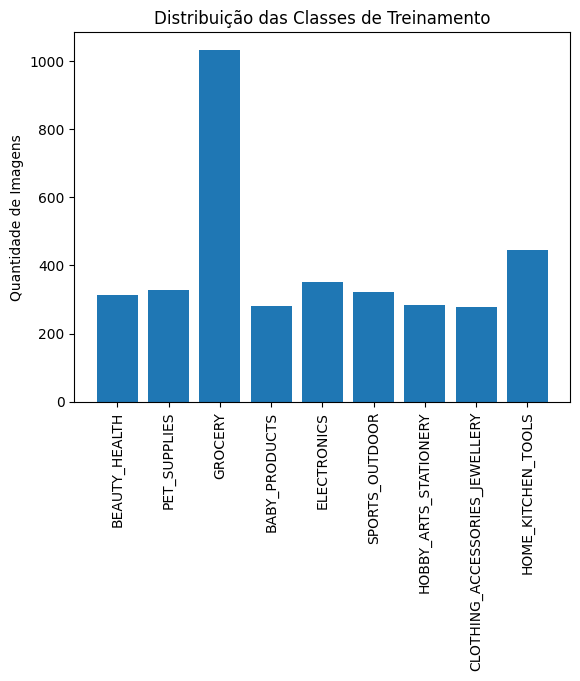

In [ ]:
plt.bar(subdiretorios.keys(), subdiretorios.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Classes de Treinamento")
plt.show()

Com a análise podemos observar que a classe GROCERY possui significativamente mais instâncias em comparação com as demais classes, sugerindo um desequilíbrio considerável na distribuição das classes no conjunto de dados.

### **CHECK - VAL**
Faremos o mesmo para o conjunto de validação (val) e conjunto de verificação (check)

#### **VAL**

In [ ]:
#análise da distribuição da classe: TRAIN
data =  '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val'
subdiretorios = {}
# Passando por cada subdiretório
for dirpath, dirnames, filenames in os.walk(data):
    if dirpath == data: continue

    num_images = 0
    # Conta o número de imagens no subdiretório
    for filename in filenames:
        if filename.lower().endswith('.jpeg'):
            num_images += 1

    # Imprimi o número de imagens do subdiretório atual
    print(f"São {num_images} imagens no diretório {os.path.basename(dirpath)}")
    subdiretorios[os.path.basename(dirpath)] = num_images

print(f"Subdiretórios: {subdiretorios}")

Subdiretórios: {}


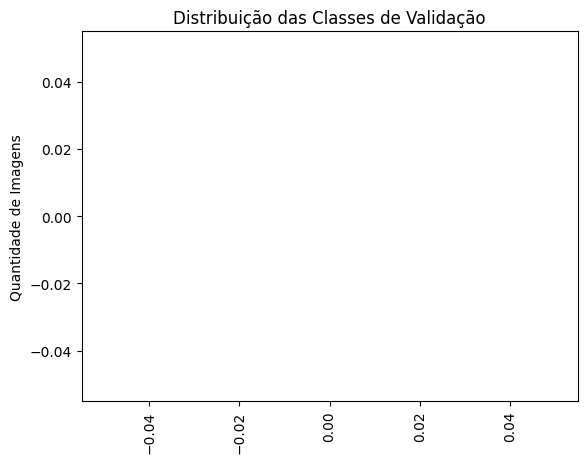

In [ ]:


plt.bar(subdiretorios.keys(), subdiretorios.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Classes de Validação")
plt.show()

#### **CHECK**

In [ ]:
#análise da distribuição da classe: TRAIN
data =  '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check'
subdiretorios = {}
# Passando por cada subdiretório
for dirpath, dirnames, filenames in os.walk(data):
    if dirpath == data: continue

    num_images = 0
    # Conta o número de imagens no subdiretório
    for filename in filenames:
        if filename.lower().endswith('.jpeg'):
            num_images += 1

    # Imprimi o número de imagens do subdiretório atual
    print(f"São {num_images} imagens no diretório {os.path.basename(dirpath)}")
    subdiretorios[os.path.basename(dirpath)] = num_images

print(f"Subdiretórios: {subdiretorios}")

Subdiretórios: {}


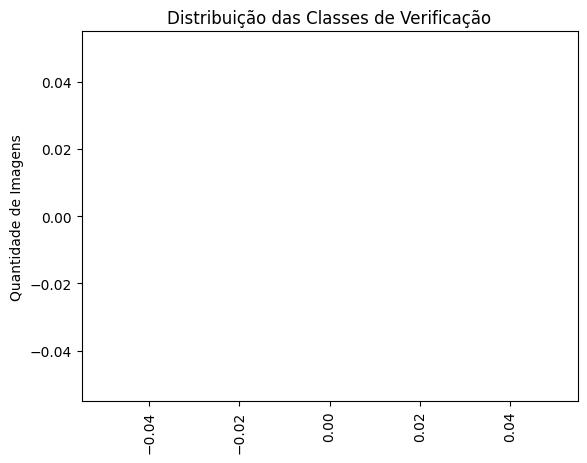

In [ ]:
plt.bar(subdiretorios.keys(), subdiretorios.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Classes de Verificação")
plt.show()

## **Duplicatas**


1.   Identifique imagens duplicadas que possam enviesar os resultados.

2.   Verifique duplicatas no arquivo de informações.

In [ ]:
# Diretórios contendo as imagens
data_dirs = [
    '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check',
    '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train',
    '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val'
]

# Função para calcular hash de uma imagem
def calculate_image_hash(image_path):
    with Image.open(image_path) as img:
        return imagehash.phash(img)

# Identificar imagens duplicadas
image_hashes = {}
duplicates = []
dir_duplicate_counts = {dir: 0 for dir in data_dirs}

# Caminhar pelos diretórios de dados e processar as imagens
for data in data_dirs:
    for dirpath, dirnames, filenames in os.walk(data):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(dirpath, filename)
                img_hash = calculate_image_hash(image_path)

                if img_hash in image_hashes:
                    duplicates.append((image_path, image_hashes[img_hash][1]))
                    # Incrementar o contador de duplicatas para o diretório atual
                    dir_duplicate_counts[data] += 1
                else:
                    image_hashes[img_hash] = (filename, dirpath)

# Deletar imagens duplicadas
for dup in duplicates:
    duplicate_path = dup[0]
    os.remove(duplicate_path)
    print(f"Deletada imagem duplicada: {duplicate_path}")

# Organizar duplicatas por diretório
duplicates_by_dir = {dir: [] for dir in data_dirs}
for path, orig_path in duplicates:
    dir = os.path.dirname(path)
    if dir not in duplicates_by_dir:
        duplicates_by_dir[dir] = []
    duplicates_by_dir[dir].append((os.path.basename(path), os.path.basename(orig_path)))

# Imprimir duplicatas por diretório
print("Imagens duplicadas por diretório (apenas primeira ocorrência mantida):")
for dir, files in duplicates_by_dir.items():
    if files:
        print(f"\n{dir}:")
        for file in files:
            print(f"{file[0]} -> {file[1]}")

# Imprimir contagem de duplicatas por diretório
print("\nContagem de duplicatas por diretório (após deleção):")
for dir, count in dir_duplicate_counts.items():
    print(f"{dir}: {count} duplicatas")

# Imprimir contagem total de duplicatas
total_duplicates = sum(dir_duplicate_counts.values())
print(f"\nTotal de duplicatas (após deleção): {total_duplicates}")


Imagens duplicadas:
17707_BEAUTY_check.jpeg -> 17688_BEAUTY_check.jpeg
17660_BABY_P_check.jpeg -> 17659_BABY_P_check.jpeg
17656_BABY_P_check.jpeg -> 17658_BABY_P_check.jpeg
17718_CLOTHI_check.jpeg -> 17720_CLOTHI_check.jpeg
1738_BEAUTY_train.jpeg -> 1739_BEAUTY_train.jpeg
1976_BEAUTY_train.jpeg -> 1805_BEAUTY_train.jpeg
1814_BEAUTY_train.jpeg -> 1818_BEAUTY_train.jpeg
2226_BEAUTY_train.jpeg -> 2151_BEAUTY_train.jpeg
2060_BEAUTY_train.jpeg -> 1805_BEAUTY_train.jpeg
1878_BEAUTY_train.jpeg -> 1843_BEAUTY_train.jpeg
1913_BEAUTY_train.jpeg -> 1978_BEAUTY_train.jpeg
2216_BEAUTY_train.jpeg -> 2143_BEAUTY_train.jpeg
2266_BEAUTY_train.jpeg -> 1991_BEAUTY_train.jpeg
1601_BEAUTY_train.jpeg -> 1600_BEAUTY_train.jpeg
2033_BEAUTY_train.jpeg -> 2265_BEAUTY_train.jpeg
2174_BEAUTY_train.jpeg -> 2244_BEAUTY_train.jpeg
2182_BEAUTY_train.jpeg -> 2248_BEAUTY_train.jpeg
1203_BEAUTY_train.jpeg -> 1149_BEAUTY_train.jpeg
2041_BEAUTY_train.jpeg -> 1886_BEAUTY_train.jpeg
2221_BEAUTY_train.jpeg -> 2144_BEAUTY_tra

##Resolução de Problemas encontrados

###Balanceamento de Classes

O código cria um gerador de dados de treinamento com data augmentation, aplicando técnicas como rotação, deslocamento e zoom para aumentar a diversidade das imagens. Em seguida, calcula os pesos das classes para corrigir desbalanceamentos no conjunto de dados e imprime esses pesos em um dicionário. O data augmentation é utilizado para melhorar a capacidade do modelo de generalizar e evitar que ele aprenda apenas características específicas da base de dados, tornando-o mais robusto e capaz de se adaptar a novas bases de dados semelhantes.

In [ ]:
# Função para calcular pesos das classes
def calculate_class_weights(generator):
    class_counts = generator.classes
    class_counts = np.bincount(class_counts)
    total_samples = len(class_counts)
    class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
    return class_weights

# Criar gerador de dados para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory='/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Calcular pesos das classes
class_weights = calculate_class_weights(train_generator)

print(f"Pesos das classes: {class_weights}")

Found 13992 images belonging to 9 classes.
Pesos das classes: {0: 0.0009199632014719411, 1: 0.0008319467554076539, 2: 0.0009337068160597573, 3: 0.0007390983000739098, 4: 0.00025138260432378077, 5: 0.0009165902841429881, 6: 0.0005830903790087463, 7: 0.0007936507936507937, 8: 0.0008097165991902834}


Após verficar o balançeamento inicial das classes, foi-se criado um gerador de dados novamente utilizando o data augmentation para treinamento de imagens e calcula os pesos das classes para corrigir desbalanceamentos. Os pesos são então impressos por classe.

In [ ]:
# Função para calcular pesos das classes
def calculate_class_weights(generator):
    class_counts = generator.classes
    class_counts = np.bincount(class_counts)
    total_samples = len(generator.classes)
    class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}
    return class_weights

# Criar gerador de dados para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory='/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Calcular pesos das classes
class_weights = calculate_class_weights(train_generator)

# Printar pesos das classes em cada linha
print("Pesos das classes:")
for class_index, weight in class_weights.items():
    print(f"Classe {class_index}: Peso {weight:.4f}")


Found 13992 images belonging to 9 classes.
Pesos das classes:
Classe 0: Peso 1.4302
Classe 1: Peso 1.2934
Classe 2: Peso 1.4516
Classe 3: Peso 1.1491
Classe 4: Peso 0.3908
Classe 5: Peso 1.4250
Classe 6: Peso 0.9065
Classe 7: Peso 1.2339
Classe 8: Peso 1.2588


# Parte 2 - Exploração de soluções

## Objetivo e informações esperadas

Objetivo:
  * Apresentar métodos da literatura e propor ideias para métodos próprios.

Informações esperadas:
  * Métodos da literatura

    1. Todos devem executar um ou mais códigos (exemplos de códigos podem ser encontrados em Related Notebooks no endereço do dataset) que resolvem o problema do projeto.
  * Métodos próprios
    1. Apresentar ideias que podem melhorar os métodos encontrados e testados da literatura.
    2. Ideias para melhorar uma técnica
      * Otimização de Hiperparâmetros - alterar ou reduzir os hiperparâmetros.
      * Elaborar uma nova arquitetura mais leve para que o treino e o teste sejam rápidos.
      * Reduzir número de imagens no treinamento e manter o desempenho.

Informações complementares:
  * Elaborar uma apresentação para mostrar os métodos da literatura e próprios.


##Pré-processamento de imagens

###Normalização

In [ ]:
# Função para converter strings como '142.365 MB' em bytes
def convert_size_to_bytes(size_str):
    size_str = size_str.strip()
    size, unit = size_str.split(' ')
    size = float(size)

    if unit == 'KB':
        return size * 1024
    elif unit == 'MB':
        return size * 1024**2
    elif unit == 'GB':
        return size * 1024**3
    else:
        return size  # Assumindo que o valor já está em bytes

# Aplicar a função à coluna 'distribution__contentSize'
df['contentSize_bytes'] = df['distribution__contentSize'].apply(convert_size_to_bytes)

# Agora você pode normalizar essa nova coluna
scaler = StandardScaler()
df['normalized_contentSize'] = scaler.fit_transform(df[['contentSize_bytes']])

# Visualizar as primeiras linhas da coluna normalizada
print(df[['distribution__contentSize', 'contentSize_bytes', 'normalized_contentSize']].head())


NameError: name 'df' is not defined

In [ ]:
def load_image(image_path):
    """Carrega uma imagem do caminho especificado e a converte para um array NumPy."""
    try:
        img = Image.open(image_path).convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

def normalize_image(img_array):
    """Normaliza a imagem para o intervalo [0, 1]."""
    if img_array is None:
        return None
    return img_array / 255.0

def plot_images(images, titles=None):
    """Plota as imagens em uma grade."""
    n = len(images)
    if n == 0:
        print("Nenhuma imagem para exibir.")
        return
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    plt.show()

def process_images(image_dir):
    """Processa todas as imagens em um diretório, removendo valores ausentes e normalizando as imagens."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

    if len(image_files) == 0:
        print("Nenhuma imagem encontrada no diretório.")
        return

    images = []
    titles = []
    for image_file in image_files[:5]:  # Limite o número de imagens a serem plotadas
        image_path = os.path.join(image_dir, image_file)
        img_array = load_image(image_path)
        if img_array is not None:
            normalized_img = normalize_image(img_array)
            if normalized_img is not None:
                images.append(normalized_img)
                titles.append(image_file)

    if images:
        plot_images(images, titles)

# Diretórios para treinamento, validação e teste
train_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train"
val_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val"
test_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check"

# Processar e plotar imagens de cada diretório
print("Processando imagens de treinamento...")
process_images(train_dir)

print("Processando imagens de validação...")
process_images(val_dir)

print("Processando imagens de teste...")
process_images(test_dir)


Processando imagens de treinamento...
Nenhuma imagem encontrada no diretório.
Processando imagens de validação...
Nenhuma imagem encontrada no diretório.
Processando imagens de teste...
Nenhuma imagem encontrada no diretório.


In [ ]:
!ls /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train
!ls /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val
!ls /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check


ls: cannot access '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train': No such file or directory
ls: cannot access '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val': No such file or directory
ls: cannot access '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check': No such file or directory


In [ ]:
def load_image(image_path):
    """Carrega uma imagem do caminho especificado e a converte para um array NumPy."""
    try:
        img = Image.open(image_path).convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

def normalize_image(img_array):
    """Normaliza a imagem para o intervalo [0, 1]."""
    if img_array is None:
        return None
    return img_array / 255.0

def plot_images(images, titles=None):
    """Plota as imagens em uma grade."""
    n = len(images)
    if n == 0:
        print("Nenhuma imagem para exibir.")
        return
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles:
            axes[i].set_title(titles[i])
    plt.show()

def list_files(directory):
    """Lista os arquivos em um diretório."""
    try:
        files = os.listdir(directory)
        print(f"Arquivos no diretório {directory}: {files}")
        return files
    except Exception as e:
        print(f"Erro ao listar arquivos no diretório {directory}: {e}")
        return []

def process_images(image_dir):
    """Processa todas as imagens em um diretório, removendo valores ausentes e normalizando as imagens."""
    if not os.path.exists(image_dir):
        print(f"Diretório {image_dir} não encontrado.")
        return

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

    if len(image_files) == 0:
        print(f"Nenhuma imagem encontrada no diretório {image_dir}.")
        return

    images = []
    titles = []
    for image_file in image_files[:5]:  # Limite o número de imagens a serem plotadas
        image_path = os.path.join(image_dir, image_file)
        img_array = load_image(image_path)
        if img_array is not None:
            normalized_img = normalize_image(img_array)
            if normalized_img is not None:
                images.append(normalized_img)
                titles.append(image_file)

    if images:
        plot_images(images, titles)

# Verificar diretórios e processar imagens
print("Verificando e processando imagens de treinamento...")
process_images(train_dir)

print("Verificando e processando imagens de validação...")
process_images(val_dir)

print("Verificando e processando imagens de teste...")
process_images(test_dir)


Verificando e processando imagens de treinamento...
Nenhuma imagem encontrada no diretório /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train.
Verificando e processando imagens de validação...
Nenhuma imagem encontrada no diretório /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val.
Verificando e processando imagens de teste...
Nenhuma imagem encontrada no diretório /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check.


###Redimensionar tamanho

Para diminuir o tamanho das imagens e otimizar o futuro treinamento, foi utilizado o **PCA** *(Principal Component Analysis ou Análise de Componentes Principais)*, uma técnica estatística que reduz a dimensionalidade dos dados enquanto preserva a maior parte da variância. Isso permite compactar as imagens sem perder informações cruciais para o modelo.

In [ ]:
def apply_pca(directory, pca_components):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        directory=directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    def fit_pca_in_batches():
        X_flat_all = []
        y_all = []
        for X_batch, y_batch in generator:
            X_flat = X_batch.reshape(X_batch.shape[0], -1)
            X_flat_all.append(X_flat)
            y_all.append(y_batch)
            if len(X_flat_all) * generator.batch_size >= pca_components:
                X_flat_all = np.vstack(X_flat_all)
                y_all = np.vstack(y_all)
                break

        if X_flat_all.shape[0] < pca_components:
            print(f"Quantidade de dados ({X_flat_all.shape[0]}) é menor que o número de componentes ({pca_components}).")
            return False, None, None

        pca = PCA(n_components=pca_components)
        pca.fit(X_flat_all)
        X_pca = pca.transform(X_flat_all)
        return True, X_pca, y_all

    success, X_pca, y_all = fit_pca_in_batches()
    if success:
        print(f"PCA aplicado com sucesso para o diretório {directory}.")
        return X_pca, y_all
    else:
        print(f"Falha ao ajustar PCA para o diretório {directory}.")
        return None, None

directories = [
    '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train',
    '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val',
    '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check'
]
pca_components = 50

pca_results = {}
for directory in directories:
    X_pca, y_all = apply_pca(directory, pca_components)
    if X_pca is not None:
        pca_results[directory] = (X_pca, y_all)


Found 13992 images belonging to 9 classes.
PCA aplicado com sucesso para o diretório /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train.
Found 3632 images belonging to 9 classes.
PCA aplicado com sucesso para o diretório /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val.
Found 551 images belonging to 9 classes.
PCA aplicado com sucesso para o diretório /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check.


###Filtragem

#####Conversão para escala cinza, Suavização de imagem e redução de ruído
O código cria um gerador de dados com data augmentation e aplica filtros de pré-processamento em imagens (escala de cinza, suavização e redução de ruído). Ele então visualiza algumas imagens originais e processadas para verificar os resultados.

Found 13992 images belonging to 9 classes.


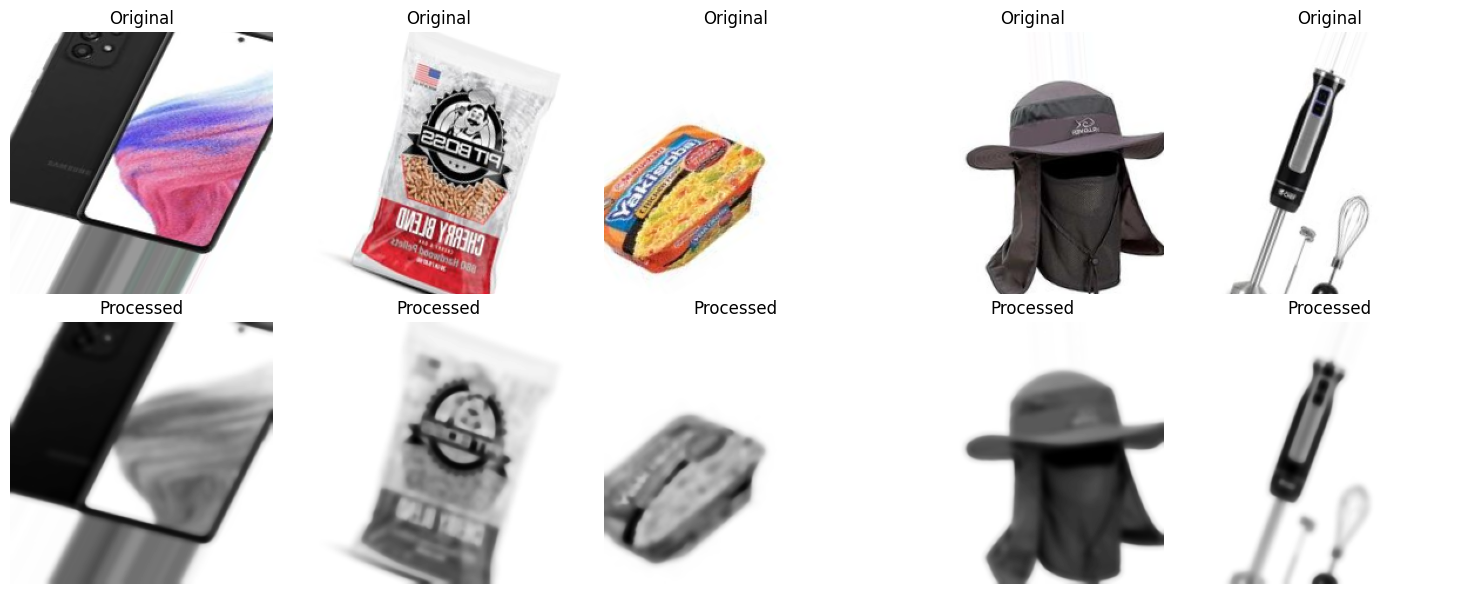

A aplicação de filtros foi verificada com sucesso.


In [ ]:
# Função para converter imagens para escala de cinza e aplicar filtros
def preprocess_image(image, label):
    # Converter para escala de cinza
    gray_image = tf.image.rgb_to_grayscale(image)

    # Converter a imagem para o formato numpy para aplicar filtros com OpenCV
    gray_image_np = gray_image.numpy().squeeze()  # Remove dimensão extra
    gray_image_np = (gray_image_np * 255).astype(np.uint8)  # Escalar de volta para 0-255

    # Aplicar Filtro Gaussiano para suavização
    smoothed_image = cv2.GaussianBlur(gray_image_np, (5, 5), 0)

    # Aplicar Filtro Bilateral para redução de ruído
    bilateral_image = cv2.bilateralFilter(smoothed_image, d=9, sigmaColor=75, sigmaSpace=75)

    # Converter a imagem filtrada de volta para o formato TensorFlow
    bilateral_image_tf = tf.convert_to_tensor(bilateral_image, dtype=tf.float32) / 255.0
    bilateral_image_tf = tf.expand_dims(bilateral_image_tf, axis=-1)  # Adicionar dimensão de canal

    return bilateral_image_tf, label

# Criar gerador de dados para treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory='/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train',
    target_size=(224, 224),
    color_mode='rgb',  # Mantenha a imagem em RGB inicialmente
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Função para verificar a aplicação de filtros
def check_image_processing(generator):
    # Obter um lote de imagens e labels
    images, labels = next(generator)

    # Aplicar pré-processamento
    processed_images, _ = zip(*[preprocess_image(img, lbl) for img, lbl in zip(images, labels)])
    processed_images = np.array(processed_images)

    # Plotar algumas imagens originais e processadas
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(5):
        # Imagem original
        axes[i].imshow(images[i])
        axes[i].set_title('Original')
        axes[i].axis('off')

        # Imagem processada
        axes[i + 5].imshow(processed_images[i].squeeze(), cmap='gray')
        axes[i + 5].set_title('Processed')
        axes[i + 5].axis('off')

    plt.tight_layout()
    plt.show()

# Verificar o pré-processamento das imagens
check_image_processing(train_generator)

print("A aplicação de filtros foi verificada com sucesso.")


####Conversão para escala de cinza

In [ ]:
# Configurar os caminhos das pastas
source_dir = '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train'
destination_dir = '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_escalacinza'

# Criar a pasta de destino se não existir
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

def convert_to_grayscale_and_save(source_dir, destination_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                # Caminho completo do arquivo de origem
                source_file_path = os.path.join(root, file)

                # Caminho completo do arquivo de destino
                relative_path = os.path.relpath(root, source_dir)
                dest_subdir = os.path.join(destination_dir, relative_path)
                dest_file_path = os.path.join(dest_subdir, file)

                # Criar subdiretórios no destino, se necessário
                if not os.path.exists(dest_subdir):
                    os.makedirs(dest_subdir)

                # Carregar a imagem
                image = cv2.imread(source_file_path)

                # Converter para escala de cinza
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Salvar a imagem convertida na pasta de destino
                cv2.imwrite(dest_file_path, gray_image)

# Converter as imagens e salvar na nova pasta
convert_to_grayscale_and_save(source_dir, destination_dir)

print("Conversão para escala de cinza concluída com sucesso!")


####Detectação de bordas

In [ ]:
# Define o caminho da nova pasta de saída
output_folder = os.path.join(data_dir, f"train_detecbordas")

# Certifique-se de que o diretório de saída existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Itera sobre as pastas (classes)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        # Cria a pasta correspondente no diretório de saída
        output_class_path = os.path.join(output_folder, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Itera sobre as imagens dentro da pasta da classe
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Carrega a imagem
            image = cv2.imread(image_path, 0)  # Carrega em escala de cinza

            # Verifica se a imagem foi carregada corretamente
            if image is None:
                print(f"Erro ao carregar a imagem: {image_path}")
                continue

            # Detecta bordas usando o algoritmo de Canny
            edges = cv2.Canny(image, 100, 200)

            # Define o caminho de saída para a imagem processada
            output_image_path = os.path.join(output_class_path, image_name)

            # Salva a imagem processada
            cv2.imwrite(output_image_path, edges)

            print(f"Bordas detectadas e imagem salva em: {output_image_path}")
print(f"Processamento concluído! Imagens salvas em: {output_folder}")

A saída de streaming foi truncada nas últimas 5000 linhas.
Bordas detectadas e imagem salva em: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_detecbordas/HOME_KITCHEN_TOOLS/10366_HOME_K_train.jpeg
Bordas detectadas e imagem salva em: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_detecbordas/HOME_KITCHEN_TOOLS/10331_HOME_K_train.jpeg
Bordas detectadas e imagem salva em: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_detecbordas/HOME_KITCHEN_TOOLS/11033_HOME_K_train.jpeg
Bordas detectadas e imagem salva em: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_detecbordas/HOME_KITCHEN_TOOLS/10063_HOME_K_train.jpeg
Bordas detectadas e imagem salva em: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_detecbordas/HOME_KITCHEN_TOOLS/11412_HOME_K_train.jpeg
Bordas detectadas e imagem salva em: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_detecbordas/HOME_KITCHEN_TOOLS